# Importing and visualizing data

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import seaborn as sb
from cart import CART, Forest
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from IPython.display import display

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('kaggle_data/adult.data')

Let's take a look at our dataset

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


`Workclass`, `education`, `martial-status`, `occupation`, `relationship`, `race`, `sex`, `native-country` are all categorial. We should encode them first. To do so we use standard LabelEncoder from sklearn.preprocessing

In [5]:
def encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

df, encoders = encode_features(df)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


And now our categorial features are all encoded. Let's make some histograms!

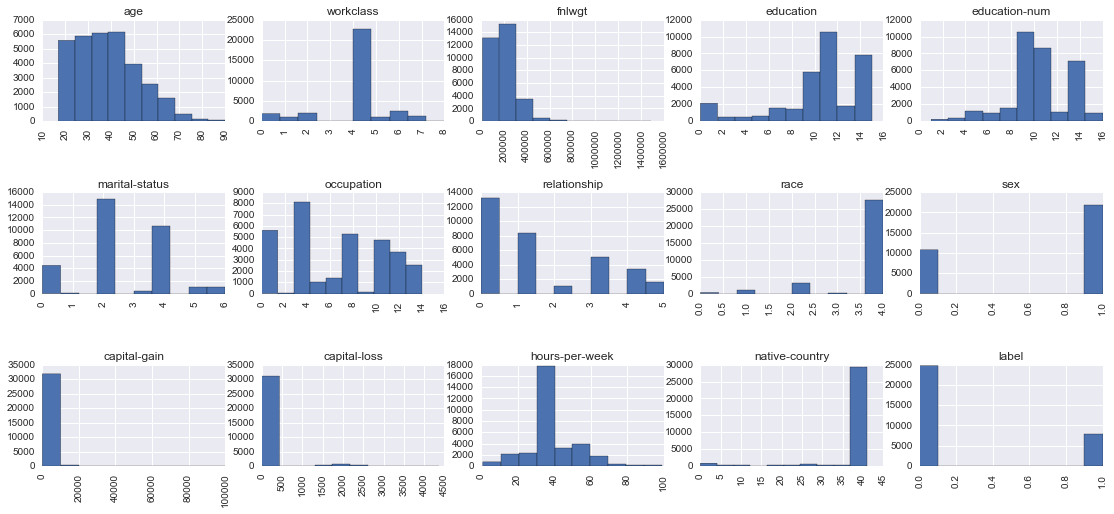

In [6]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    df[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Hmm, looks like most of the people in our dataset have salary below $50K and that is before taxes! Well, too bad. 

If we take a look on correlation matrix between numerical features we can see that ones with higher education level make more money. There is also positive correlation between workload and salary and age and salary.

By the way, our correlation matrix shows us that women make less money than men. That's just because our dataset is sexist. 

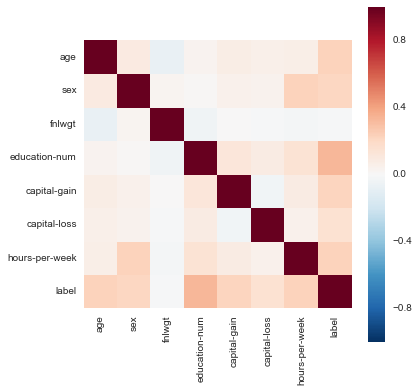

In [18]:
plt.figure(figsize=(6, 6))
columns = ["age", "sex", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week", "label"]
sb.heatmap(df[columns].corr(), square=True)
plt.show()

OK. Lets finally make our X_train and Y_train.

In [20]:
X_train, Y_train = df[df.columns[:-1]].values, df[df.columns[-1]].values

## Decision tree (CART)

Implementation of descision tree building can be found in ```cart.py```. I've used this course (https://www.coursera.org/learn/supervised-learning/) on Coursera from Yandex team to understand descision tree building. I've implemented 3 different metrics: 'twoing', 'gini' and 'entropy'. I've used the following stopping criterion: 
```python
(len(self.Y_train) <= self.leaf_size or self.num_unique_ys == 1 or self.__gini(self.Y_train) <= 0.001 or self.depth >= self.max_depth)
```

In [27]:
cart = CART(leaf_size=1, max_depth=5, criterion='twoing')
%time cart.fit(X_train[1000:], Y_train[1000:])

CPU times: user 36.4 s, sys: 290 ms, total: 36.7 s
Wall time: 36.9 s


In [28]:
%time y_pred = cart.predict(X_train[:1000])

CPU times: user 3.98 ms, sys: 2.34 ms, total: 6.32 ms
Wall time: 5.54 ms


In [29]:
metrics.f1_score(Y_train[:1000], y_pred)

0.59999999999999987

## Tree visualisation

To visualize the tree let's use dot utility from graphviz to convert dot file format syntax to png and then load it in ipython

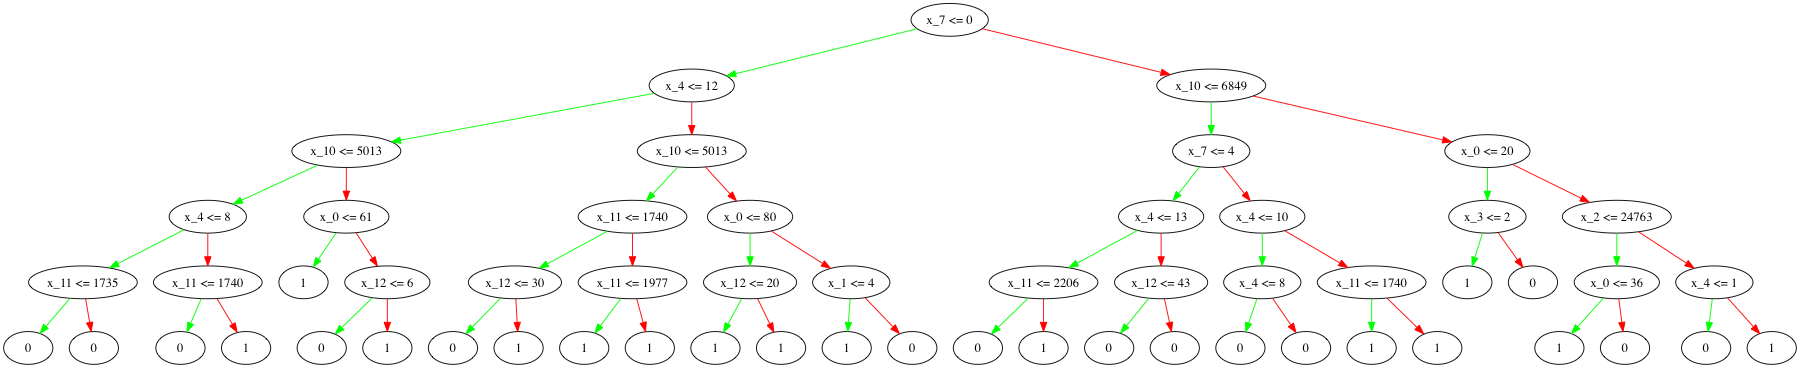

In [36]:
value = cart.dotfile()
open('tree.dot', 'w').write(value)
!dot -Tpng -Gdpi=200 -Gsize=9,15 tree.dot -o tree.png
Image('tree.png')

This tree looks valid enough given the correlations we`ve got in the data.

## Tree comparison visualisation

Now let's visualize partition surface for both CART and kNN algorithms. We use 3 2-dimensional datasets: linearly separable dataset, circles dataset and moons dataset. Original datasets can be found on the left. kNN results can be found in the middle and CART results on the right.

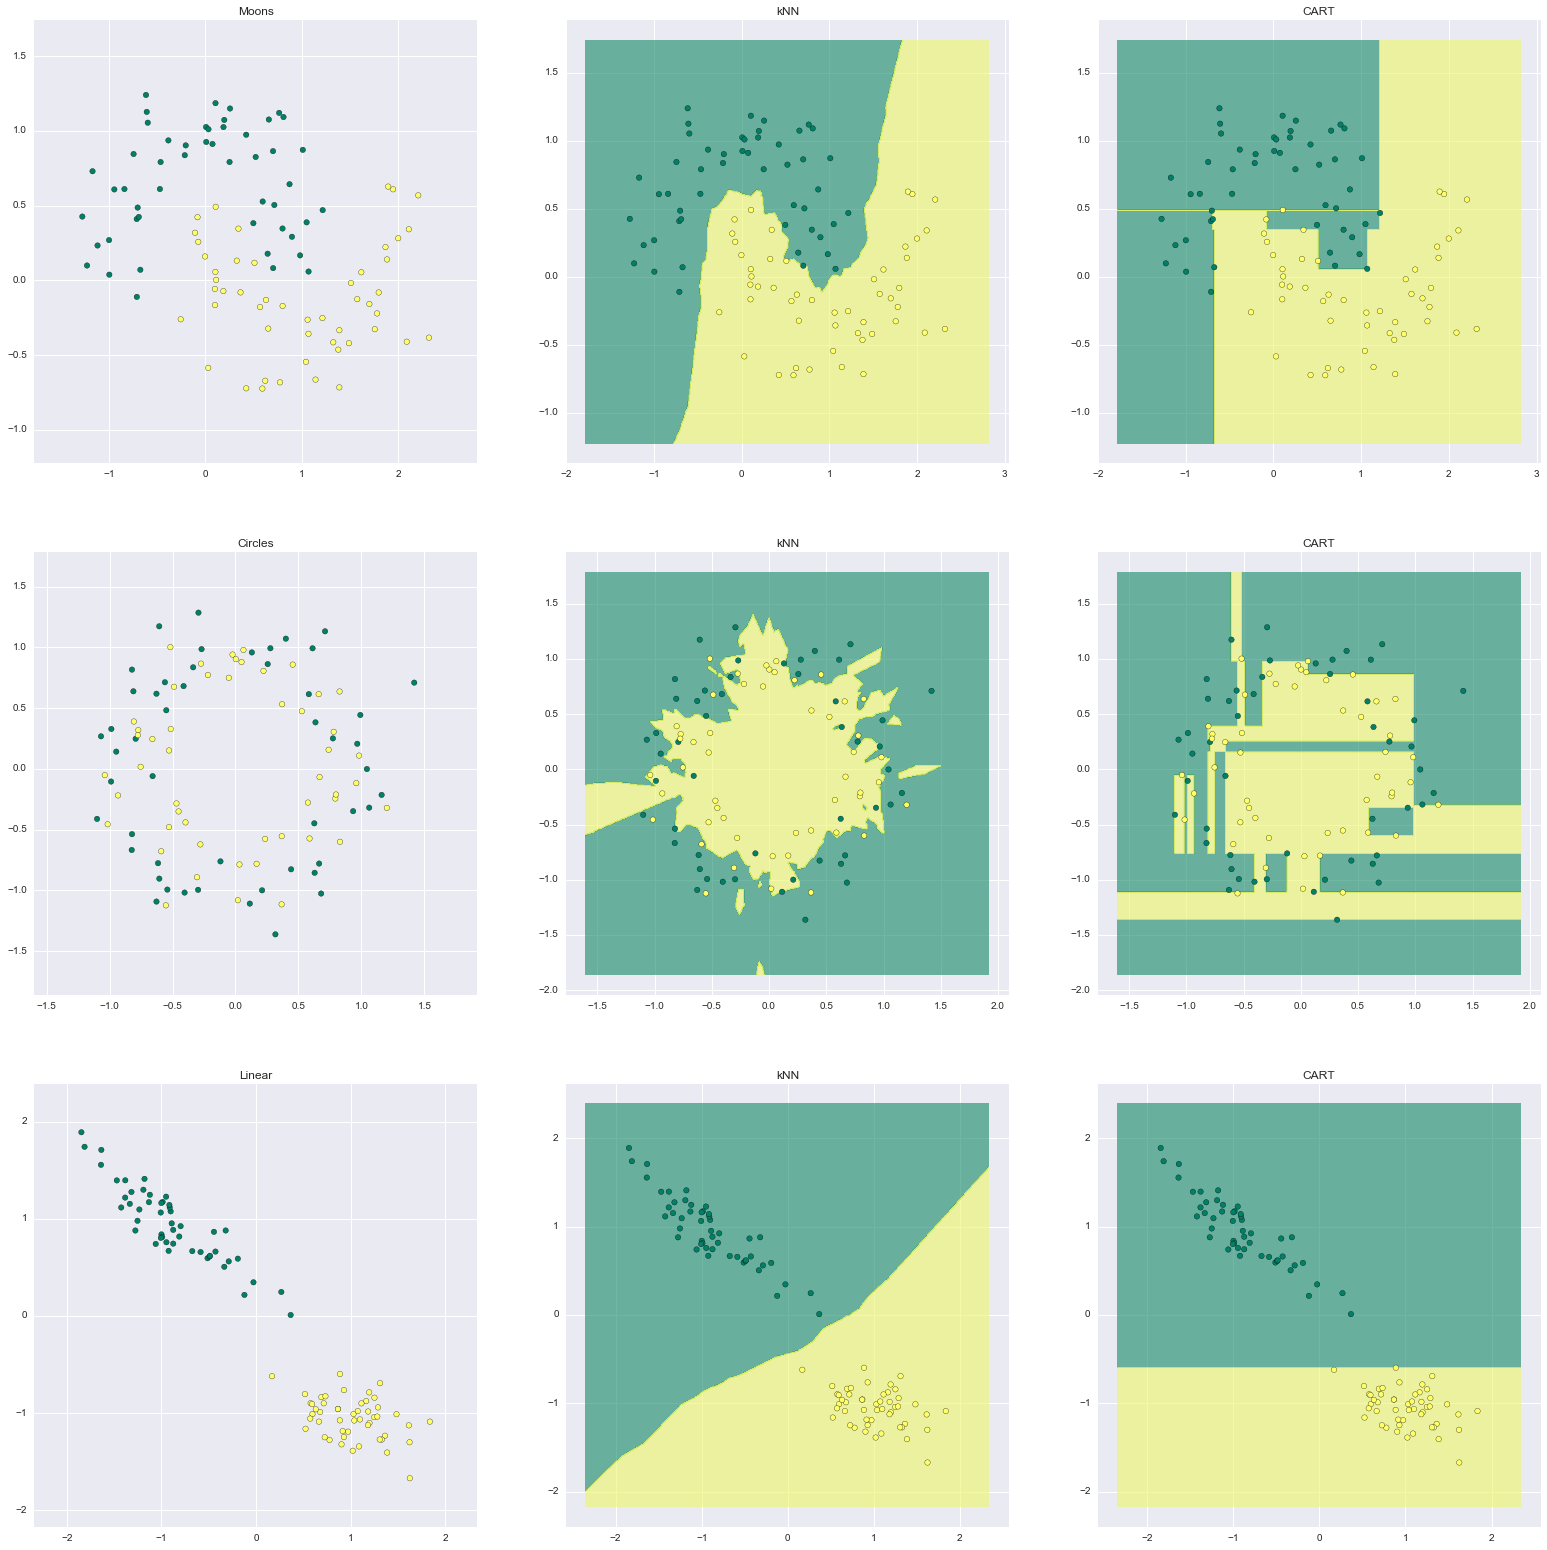

In [38]:
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

dataset_names = ["Moons", "Circles", "Linear"]
datasets = [make_moons(noise=0.2), make_circles(noise=0.2),
make_classification(n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=6)]
classifiers = [KNeighborsClassifier(), CART(1, 10, 'gini')]
names = ["kNN", "CART"]
i = 0
plt.figure(figsize=(27, 27))


for ds, name in zip(datasets, dataset_names):
    i += 1
    X, y = ds
    min_x, max_x = min(X[:, 0]) - .5, max(X[:, 0]) + .5
    min_y, max_y = min(X[:, 1]) - .5, max(X[:, 1]) + .5
    xs = np.linspace(min_x, max_x, 500)
    ys = np.linspace(min_y, max_y, 500)
    xx, yy = np.meshgrid(xs, ys)
    ax = plt.subplot(3, 3, i)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.summer, s=30)
    ax.set_title(name)
    for clf, name in zip(classifiers, names):  
        i += 1
        ax = plt.subplot(3, 3, i)
        clf.fit(X, y)
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        z = z.reshape(xx.shape)
        ax.contourf(xx, yy, z, cmap=plt.cm.summer, alpha=.6)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.summer, s=30)
        ax.set_title(name)
    
plt.show()

## Tree bagging
The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X=x_1,...,x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($ B $ times) selects a random sample with replacement of the training set and fits trees to these samples.
After training, predictions for unseen samples $ x' $ can be made by averaging the predictions from all the individual regression trees on $x'$:

$$ \hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x') $$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

Implementation of random forest algorithm can be found in the cart.py. Now we can visualize the difference between random forest and CART using the same method as above.

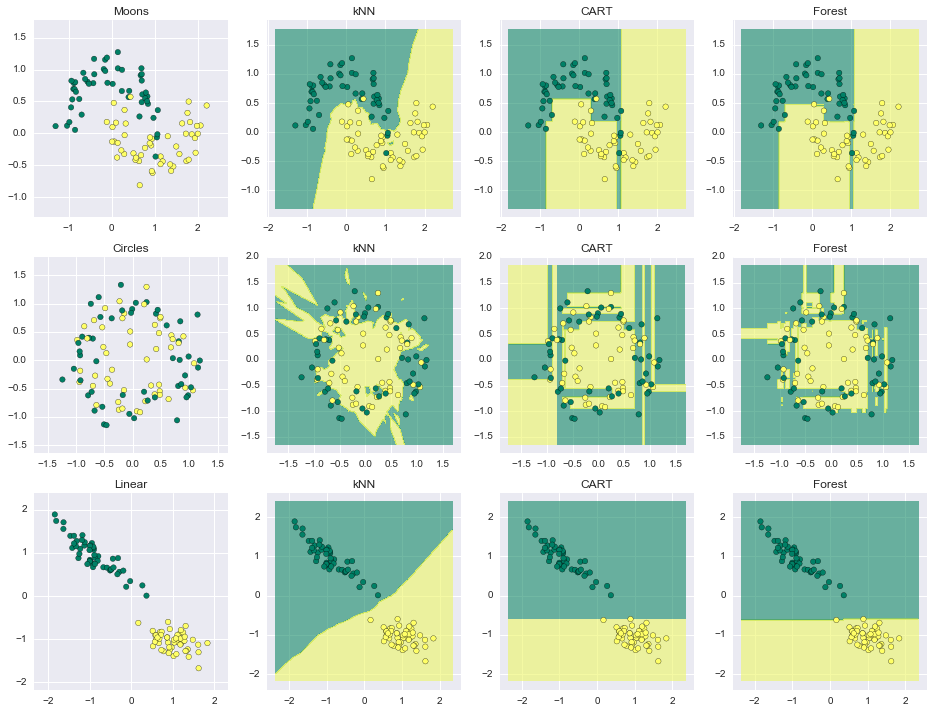

In [39]:
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

dataset_names = ["Moons", "Circles", "Linear"]
datasets = [make_moons(noise=0.2), make_circles(noise=0.2),
make_classification(n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=6)]
classifiers = [KNeighborsClassifier(), CART(1, 10, 'gini'), Forest(100, 1, 10, 'gini')]
names = ["kNN", "CART", "Forest"]
i = 0
plt.figure(figsize=(16, 12))


for ds, name in zip(datasets, dataset_names):
    i += 1
    X, y = ds
    min_x, max_x = min(X[:, 0]) - .5, max(X[:, 0]) + .5
    min_y, max_y = min(X[:, 1]) - .5, max(X[:, 1]) + .5
    xs = np.linspace(min_x, max_x, 500)
    ys = np.linspace(min_y, max_y, 500)
    xx, yy = np.meshgrid(xs, ys)
    ax = plt.subplot(3, 4, i)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.summer, s=30)
    ax.set_title(name)
    for clf, name in zip(classifiers, names):  
        i += 1
        ax = plt.subplot(3, 4, i)
        clf.fit(X, y)
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        z = z.reshape(xx.shape)
        ax.contourf(xx, yy, z, cmap=plt.cm.summer, alpha=.6)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.summer, s=30)
        ax.set_title(name)
    
plt.show()

It seems like forest is more robust that just one decision tree especially on circles dataset.

## Implement F1 score function and Cross Validation

In [65]:
def f1(y_true, y_pred):
    tp = np.count_nonzero(np.logical_and(y_true == 1, y_pred == 1))
    precision = tp / float(len(y_pred[y_pred == 1]))
    recall = tp / float(len(y_true[y_true == 1]))
    print precision
    print recall
    print tp
    return 2 * precision * recall / (precision + recall)

print f1(np.array([0, 0, 1]), np.array([1, 0, 1]))
print metrics.f1_score(np.array([0, 0, 1]), np.array([1, 0, 1]))

0.5
1.0
1
0.666666666667
0.666666666667


In [69]:
def cross_validation(X, y, clf, score, cv_fold=2):
    scores = []
    num_data = X.shape[0]
    ind = np.arange(num_data)
    np.random.shuffle(ind)
    X_part = []
    Y_part = []
    block_size = num_data // cv_fold
    for i in range(cv_fold):
        ind_block = ind[i * block_size : (i + 1) * block_size]
        X_part.append(X[ind_block])
        Y_part.append(y[ind_block])
    X_part = np.array(X_part)
    Y_part = np.array(Y_part)
    for i in range(cv_fold):
        X_train_new = np.concatenate(X_part[np.arange(len(X_part)) != i])
        Y_train_new = np.concatenate(Y_part[np.arange(len(Y_part)) != i])
        X_test_new = X_part[i]
        Y_test_new = Y_part[i]
        clf.fit(X_train_new, Y_train_new)
        Y_pred = clf.predict(X_test_new)
        scores.append(score(Y_test_new, Y_pred))
    return np.mean(scores)

In [70]:
from sklearn.ensemble import RandomForestClassifier
for n_est in [10, 30, 50]:
    for max_depth in [10, 15, 20, 30, 50, 100, None]:
        for crit in ["gini", "entropy"]:
            forest = Forest(num_trees=n_est, max_depth=max_depth, leaf_size=1, criterion=crit)
            score = cross_validation(X_train, Y_train, cart, metrics.f1_score)
            print("n_est: {n_est} depth: {depth} {crit} {score}".format(crit=crit, depth=max_depth, n_est=n_est, score=score))

n_est: 10 depth: 10 gini 0.669254683711
n_est: 10 depth: 10 entropy 0.661372556726
n_est: 10 depth: 15 gini 0.666567276435
n_est: 10 depth: 15 entropy 0.669582118562
n_est: 10 depth: 20 gini 0.653318468381
n_est: 10 depth: 20 entropy 0.659178200841
n_est: 10 depth: 30 gini 0.638543132987
n_est: 10 depth: 30 entropy 0.64498226498
n_est: 10 depth: 50 gini 0.63624572731
n_est: 10 depth: 50 entropy 0.643035536682
n_est: 10 depth: 100 gini 0.649199442652
n_est: 10 depth: 100 entropy 0.644057318668
n_est: 10 depth: None gini 0.645554905834
n_est: 10 depth: None entropy 0.645337537849
n_est: 30 depth: 10 gini 0.667747785009
n_est: 30 depth: 10 entropy 0.660974198606
n_est: 30 depth: 15 gini 0.678528438929
n_est: 30 depth: 15 entropy 0.673739085375
n_est: 30 depth: 20 gini 0.665841147764
n_est: 30 depth: 20 entropy 0.668590452673
n_est: 30 depth: 30 gini 0.660160851142
n_est: 30 depth: 30 entropy 0.665795429896
n_est: 30 depth: 50 gini 0.657518450923
n_est: 30 depth: 50 entropy 0.657207179175


In [73]:
from sklearn.ensemble import RandomForestClassifier
for max_depth in [5, 10, 15, 20, 30, 50, 100, None]:
    for crit in ["gini", "entropy"]:
        cart = CART(max_depth=max_depth, criterion=crit, leaf_size=1)
        score = cross_validation(X_train, Y_train, cart, metrics.f1_score)
        print("depth: {depth} {crit} {score}".format(crit=crit, depth=max_depth, n_est=n_est, score=score))

depth: 5 gini 0.627011018455
depth: 5 entropy 0.615831025015
depth: 10 gini 0.666719977202
depth: 10 entropy 0.629025077905
depth: 15 gini 0.617624084874
depth: 15 entropy 0.636917825683
depth: 20 gini 0.621923597307
depth: 20 entropy 0.622812847165
depth: 30 gini 0.596929734696
depth: 30 entropy 0.610054986614
depth: 50 gini 0.597462087474
depth: 50 entropy 0.612063544251
depth: 100 gini 0.607773090836
depth: 100 entropy 0.596354283315
depth: None gini 0.595307406502
depth: None entropy 0.608902123353


# Kaggle

In [10]:
forest = Forest(num_trees=50, leaf_size=4, max_depth=15)
%time forest.fit(X_train, Y_train)

CPU times: user 1h 17min 48s, sys: 9min 45s, total: 1h 27min 34s
Wall time: 34min 39s


<cart.Forest instance at 0x117df9488>

In [32]:
df_test = pd.read_csv('kaggle_data/adult.val')

In [33]:
df_test, _ = encode_features(df_test)

In [34]:
X_test = df_test.values

In [35]:
Y_test_pred = map(int, forest.predict(X_test))

In [36]:
df_test_y = pd.DataFrame(Y_test_pred)

In [37]:
df_test_y.to_csv('kaggle_data/cart_predict_100_depth_10_leaf_retry.csv')

# Выводы

Не смотря на то, что Forest показал хорошие результаты локально, мне не удалось использовать его на kaggle в полную мощь, отчасти из-за того, что Forest с достаточным количеством деревьем (n_est=200) фитился очень долго, отчасти из-за того, что отсечение, которое я реализовал в одном дереве (gini(self.Y_train) <= 0.001) итак работало хорошо, и заскорило даже больше, чем форест с 50 деревьями. Вероятно, что если обучить forest с достаточно большим количеством деревьев и правильным отсечением, он наберет больше одного дерева, как и показывает кросс валидация (Forest(n_est=50, depth=15) показывает себя лучше CART(depth=15)). 